In [63]:
import pandas as pd
from collections import defaultdict, Counter
import os
import matplotlib.pyplot as plt
import sys
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_dir)
from data_generator import normalize, normalize_new_data


In [64]:
def compile_csvs(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in csv_files], ignore_index=True)
    return df

In [65]:
#Full CSV Files
rainfall = compile_csvs("../data/test_data_gov_sg/rainfall_data")
air_temperature = compile_csvs("../data/test_data_gov_sg/air-temperature_data")
wind_speed = compile_csvs("../data/test_data_gov_sg/wind-speed_data")
relative_humidity = compile_csvs("../data/test_data_gov_sg/relative-humidity_data")
wind_direction = compile_csvs("../data/test_data_gov_sg/wind-direction_data")
lightning_risk_16S = pd.read_csv("../data/lightning_risk_data_test/lightning_risk_data_per_5min_16S.csv") # Output
input_data_dfs = [rainfall, air_temperature, wind_speed, relative_humidity,wind_direction]
input_data_df_names = ["rainfall", "air_temperature", "wind_speed", "relative_humidity","wind_direction"]


In [79]:
# Columns to exclude
exclude_cols = {"Timestamp", "Date", "Time"}

# Count occurrences of each column in the DataFrames
column_counts = Counter()

for df in input_data_dfs:
    for col in df.columns:
        if col not in exclude_cols:
            column_counts[col] += 1

# Convert to DataFrame and sort in ascending order
column_counts_df = pd.DataFrame(column_counts.items(), columns=["Column", "Count"]).sort_values(by="Count")

count_dict = defaultdict(list)
for col, count in column_counts.items():
    count_dict[count].append(col)

# Convert to a regular dictionary (optional)
count_dict = dict(count_dict)

# Print result
print(count_dict.keys())
print([len(count_dict[key]) for key in count_dict.keys()])
print(count_dict)

dict_keys([5, 1, 3, 2])
[14, 47, 1, 1]
{5: ['S06', 'S104', 'S106', 'S107', 'S109', 'S111', 'S115', 'S116', 'S117', 'S121', 'S43', 'S44', 'S50', 'S60'], 1: ['S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S29', 'S33', 'S40', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94', 'S07', 'S64'], 3: ['S24'], 2: ['S108']}


In [80]:
station_ids = count_dict[5]
print(station_ids)

['S06', 'S104', 'S106', 'S107', 'S109', 'S111', 'S115', 'S116', 'S117', 'S121', 'S43', 'S44', 'S50', 'S60']


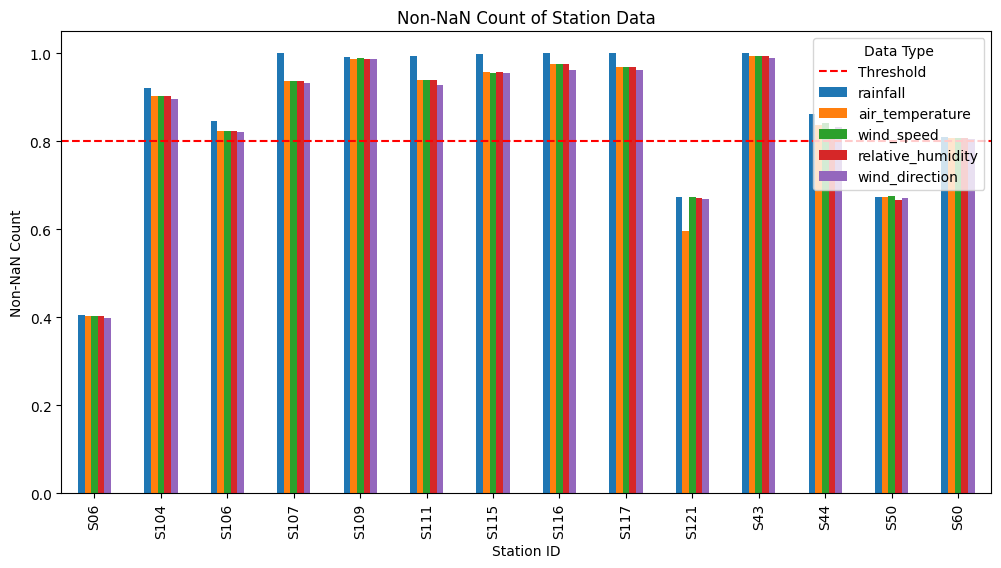

In [81]:

# Dictionary to store non-NaN counts
non_nan_counts = {}

# Compute non-NaN counts for each station_id in each dataframe
for df_name, df in zip(input_data_df_names, input_data_dfs):
    non_nan_counts[df_name] = df[station_ids].count() / df.shape[0]  # Normalized by row count


# Convert to DataFrame for visualization
non_nan_counts_df = pd.DataFrame(non_nan_counts)

# Plot bar chart
non_nan_counts_df.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Station ID")
plt.ylabel("Non-NaN Count")
plt.title("Non-NaN Count of Station Data")
plt.xticks(rotation=90)
threshold_value = 0.8  # Change this to your desired threshold
plt.axhline(y=threshold_value, color='r', linestyle='--', label="Threshold")
plt.legend(title="Data Type")
plt.show()

In [82]:
stations_to_keep = ['S104', 'S107', 'S109', 'S115', 'S116', 'S43', 'S50']
for station_to_drop in list(station_ids):  # Make a copy if modifying during iteration
    if station_to_drop not in stations_to_keep:
        station_ids.remove(station_to_drop)

In [83]:
def prepare_csv(df_raw, filename):
    df_raw["Timestamp"] = pd.to_datetime(df_raw["Timestamp"])
    
    # Extract only the required columns and filter out irrelevant stations
    selected_columns = ["Timestamp"] + station_ids
    df_selected = df_raw[selected_columns]

    # Interpolate data for short missing data
    df_filled = df_selected.interpolate(method='linear', limit=10, limit_direction='forward')

    # Filter rows where the minute is a multiple of 5
    df_filtered = df_filled[df_filled["Timestamp"].dt.minute % 5 == 0]
    if not os.path.exists("../data/test_data"):
        os.makedirs("../data/test_data")
    output_path = os.path.join("../data/test_data", filename)
    print(f"{filename} is now saved at data/test_data.")
    df_filtered.to_csv(output_path, index=False)

In [84]:
for df_name, df in zip(input_data_df_names, input_data_dfs):
    prepare_csv(df,df_name+".csv")

rainfall.csv is now saved at data/test_data.
air_temperature.csv is now saved at data/test_data.
wind_speed.csv is now saved at data/test_data.
relative_humidity.csv is now saved at data/test_data.
wind_direction.csv is now saved at data/test_data.


In [85]:
# Filter rows where the minute is a multiple of 5
lightning_risk_16S = lightning_risk_16S.rename(columns={"DateTime": "Timestamp"})
lightning_risk_16S["Timestamp"] = pd.to_datetime(lightning_risk_16S["Timestamp"])
df_filtered = lightning_risk_16S[lightning_risk_16S["Timestamp"].dt.minute % 5 == 0]
output_path = os.path.join("../data/test_data", "Lightning Risk 16S.csv")
df_filtered.to_csv(output_path, index=False)
print(f"{"Lightning Risk 16S.csv"} is now saved at data/test_data.")

Lightning Risk 16S.csv is now saved at data/test_data.


In [86]:
normalized_dfs = []
for i in range(len(input_data_dfs)):
    normalized_dfs.append(normalize_new_data(input_data_dfs[i], input_data_df_names[i]))

Done normalizing
Done normalizing
Done normalizing
Done normalizing
Done normalizing


In [87]:
os.makedirs("../data/normalized_test_data/",exist_ok=True)

In [88]:
for i in range(len(input_data_df_names)):
    normalized_dfs[i].to_csv(os.path.join("../data/normalized_test_data/",input_data_df_names[i]+".csv"))

In [89]:
filtered_input_data_dfs = []

for df in normalized_dfs:
    cols = df.columns
    df_copy = df.copy()

    # If 'Timestamp' is present, include it in the selection
    if 'Timestamp' in cols:
        filtered_df = df_copy[['Timestamp'] + [s for s in stations_to_keep if s in df_copy.columns]]
    else:
        filtered_df = df_copy[[s for s in stations_to_keep if s in df_copy.columns]]

    # Add missing columns (e.g., 'S24' might be added but others may still be missing)
    for s in stations_to_keep:
        if s not in filtered_df.columns:
            filtered_df[s] = None  # or 0 or np.nan depending on how you want to fill missing

    # Reorder columns to match stations_to_keep
    if 'Timestamp' in filtered_df.columns:
        filtered_df = filtered_df[['Timestamp'] + stations_to_keep]
    else:
        filtered_df = filtered_df[stations_to_keep]

    filtered_input_data_dfs.append(filtered_df)


In [90]:
compiled_dfs = []

for df, name in zip(filtered_input_data_dfs, input_data_df_names):
    df = df.copy()
    
    # Drop 'index' column if it was created by reset_index
    if 'index' in df.columns:
        df = df.drop(columns='index')
    
    # Rename only station columns (exclude 'Timestamp')
    station_cols = [col for col in df.columns if col != 'Timestamp']
    renamed_df = df.rename(columns={col: f"{name}_{col}" for col in station_cols})
    
    compiled_dfs.append(renamed_df)

# Merge all station datasets on Timestamp
compiled_df = compiled_dfs[0]
for df in compiled_dfs[1:]:
    compiled_df = compiled_df.merge(df, on="Timestamp", how="outer")

# Merge lightning risk data (assumes it has no conflicting column names)
if 'index' in lightning_risk_16S.columns:
    lightning_risk_16S = lightning_risk_16S.drop(columns='index')

compiled_df = compiled_df.merge(lightning_risk_16S[["Timestamp", "16S"]], on="Timestamp", how="outer")
compiled_df = compiled_df.rename(columns={"16S": "Lightning_Risk"})


In [91]:
cleaned_compiled_df = compiled_df.dropna()

In [92]:
print(len(compiled_df),len(cleaned_compiled_df))

66388 6442


In [93]:
cleaned_compiled_df.to_csv("../data/test_data/cleaned_compiled_data_normalized.csv", index=False)